# Examples of RBM, CRBM and CNN networks

## Using RRBM and RCNN packages

#### Load Libraries

In [1]:
library(rrbm);
library(rcnn);

### RBMs: the MNIST example

#### Load Dataset

In [2]:
mnist <- readRDS("../datasets/mnist.rds");

In [3]:
training_x <- mnist$train$x / 255;
training_y <- mnist$train$y;

testing_x <- mnist$test$x / 255;
testing_y <- mnist$test$y;

#### Train the RBM

In [4]:
start.time <- Sys.time()

rbm1 <- train.rbm(n_hidden = 30,
                  dataset = training_x,
                  learning_rate = 1e-3,
                  training_epochs = 10,
                  batch_size = 10,
                  momentum = 0.5
);

end.time <- Sys.time()
time.taken <- end.time - start.time
time.taken

Time difference of 9.060378 mins

#### Predict using the RBM

In [5]:
result <- predict(rbm1, training_x);

In [6]:
str(result);

List of 2
 $ reconstruction: num [1:60000, 1:784] 0.1561 0.3103 0.3778 0.7363 -0.0555 ...
 $ activation    : num [1:60000, 1:30] 0.587 0.621 0.166 0.677 0.322 ...


### CRBMs: the Motion example

#### Load Dataset

In [7]:
load_data <- function(filename)
{
    mat_dict <- readRDS(filename);
    Motion <- mat_dict[['Motion']];

    n_seq <- length(Motion);

    # assume data is MIT format for now
    indx <- c(1:9, 14, 19:21, 26, 31:33, 38, 43:45, 50, 55:57, 61:63, 67:69, 73:75,
                79:81, 85:87, 91:93, 97:99, 103:105);

    ##row1 <- Motion[[c(1,1)]][1,];
    ##offsets <- array(row1[c(10:12, 16:18, 22:24, 28:30, 34:36, 40:42, 46:48, 52:54,
    ##            58:60, 64:66, 70:72, 76:78, 82:84, 88:90, 94:96, 100:102,
    ##            106:108)], c(3, length(row1)/3) );

    # collapse sequences
    batchdata <- rbind(Motion[[c(1,1)]][,indx],
                       Motion[[c(2,1)]][,indx],
                       Motion[[c(3,1)]][,indx]);
    data_mean <- colMeans(batchdata);
    data_std <- apply(batchdata, 2, sd);

    batchdata <- t((t(batchdata) - data_mean) / data_std);

    # get sequence lengths
    seqlen <- sapply(1:3, function(x) nrow(Motion[[c(x,1)]]));

    list(batchdata = batchdata, seqlen = seqlen, data_mean = data_mean, data_std = data_std);
}

In [8]:
dataset <- load_data('../datasets/motion.rds');

In [9]:
str(dataset)

List of 4
 $ batchdata: num [1:3826, 1:49] -0.258 -0.23 -0.134 -0.234 -0.163 ...
 $ seqlen   : int [1:3] 438 260 3128
 $ data_mean: num [1:49] 1.58179 1.5854 0.00448 36.99363 -1.43077 ...
 $ data_std : num [1:49] 0.0537 0.0896 0.0403 14.3277 10.0685 ...


#### Train the CRBM

In [10]:
start.time <- Sys.time()

crbm <- train.crbm (dataset$batchdata,
                    dataset$seqlen,
                    batch_size = 100,
                    n_hidden = 100,
                    delay = 6,
                    training_epochs = 200,
                    learning_rate = 1e-3,
                    momentum = 0.5,
                    rand_seed = 1234
);

end.time <- Sys.time()
time.taken <- end.time - start.time
time.taken

Time difference of 1.176572 mins

#### Predict using the CRBM

Note: **predict** assumes that the input data is a time serie, to build the history on the fly. In the **native R** version, this function corresponds to **simulate_series_crbm**.

In [11]:
results1 <- predict(crbm, dataset$batchdata);

In [12]:
str(results1)

List of 2
 $ reconstruction: num [1:3826, 1:49] 0 0 0 0 0 0 0 0 0 0 ...
 $ activation    : num [1:3826, 1:100] 0 0 0 0 0 0 0 0 0 0 ...


#### Forecasting using the CRBM

In [13]:
results2 <- forecast.crbm(crbm, dataset$batchdata[1:(crbm$delay+1),], 50, 30);

In [14]:
str(results2)

List of 1
 $ generated: num [1:50, 1:49] 0.743 -0.936 -0.216 -1.347 1.197 ...


### CNNs: the MNIST example (again)

#### Load Dataset

In [15]:
mnist <- readRDS("../datasets/mnist.rds");

In [16]:
img_size <- c(28,28);

train <- mnist$train;
training_x <- array(train$x, c(nrow(train$x), 1, img_size)) / 255;
training_y <- binarization(train$y);

test <- mnist$test;
testing_x <- array(test$x, c(nrow(test$x), 1, img_size)) / 255;
testing_y <- binarization(test$y);

dataset <- training_x[1:1000,,,, drop=FALSE];
targets <- training_y[1:1000,, drop=FALSE];

newdata <- testing_x[1:1000,,,, drop=FALSE];

#### Prepare the Convolutional MLP Network

In [17]:
batch_size <- 10;

border_mode <- 2;
filter_size <- 5;

win_size <- 3;
stride <- 2;

In [18]:
layers <- list(
    c("CONV", 1, 4, filter_size, 0.1, border_mode, batch_size),
    c("POOL", 4, 0.1, batch_size, win_size, stride),
    c("RELU", 4, batch_size),
    c("CONV", 4, 16, filter_size, 0.1, border_mode, batch_size),
    c("POOL", 16, 0.1, batch_size, win_size, stride),
    c("RELU", 16, batch_size),
    c("FLAT", 16, batch_size),
    c("LINE", 784, 64, 0.1, batch_size),
    c("RELV", batch_size),
    c("LINE", 64, 10, 0.1, batch_size),
    c("SOFT", 10, batch_size)
#   c("SIGM", 10, batch_size)
#   c("TANH", 10, batch_size)
#   c("DIRE", 10, batch_size)
);

#### Check if the defined network has correct shapes

In [19]:
check_layers(layers, dataset, targets, batch_size);

[1] TRUE

#### Run the CNN

In [20]:
start.time <- Sys.time()

cnn1 <- train.cnn(dataset = dataset,
                  targets = targets,
                  layers = layers,
                  batch_size = batch_size,
                  training_epochs = 3,
                  learning_rate = 1e-3,
                  momentum = 0.8,
                  rand_seed = 1234
);

end.time <- Sys.time()
time.taken <- end.time - start.time
time.taken

Time difference of 2.73557 mins

In [21]:
str(cnn1)

List of 7
 $ dims.in      : int [1:4] 1000 1 28 28
 $ dims.out     : int [1:2] 1000 10
 $ layers       :List of 11
  ..$ :List of 11
  .. ..$ type       : chr "CONV"
  .. ..$ batch_size : int 100
  .. ..$ filter_size: int 5
  .. ..$ n_filters  : int 4
  .. ..$ n_channels : int 1
  .. ..$ padding    : int [1:2] 2 2
  .. ..$ win_size   : int [1:2] 5 5
  .. ..$ b          : num [1:4] 4.96e-05 1.11e-03 -5.50e-05 -5.57e-04
  .. ..$ grad_b     : num [1:4] -0.0513 0.015 -0.0758 0.0634
  .. ..$ W          : num [1:4, 1, 1:5, 1:5] -0.0563 -0.0542 -0.141 0.0751 0.0976 ...
  .. ..$ grad_W     : num [1:4, 1, 1:5, 1:5] 0 0 0 0 0 0 0 0 0 0 ...
  ..$ :List of 6
  .. ..$ type      : chr "POOL"
  .. ..$ batch_size: int 100
  .. ..$ n_channels: int 4
  .. ..$ win_size  : int 3
  .. ..$ stride    : int 2
  .. ..$ padding   : int 1
  ..$ :List of 3
  .. ..$ type      : chr "RELU"
  .. ..$ batch_size: int 100
  .. ..$ n_channels: int 4
  ..$ :List of 11
  .. ..$ type       : chr "CONV"
  .. ..$ batch_size 

## Using the R native functions

In [22]:
rm (list = ls());

#### Load the R sources

In [23]:
setwd("..");
source("./cnn.R");
source("./crbm.R");
source("./crbm_series.R");
source("./rbm.R");
setwd("notebooks");

### Native R RBMs: the MNIST example (again!)

#### Load Dataset

In [24]:
mnist <- readRDS("../datasets/mnist.rds");

In [25]:
training_x <- mnist$train$x / 255;
training_y <- mnist$train$y;

testing_x <- mnist$test$x / 255;
testing_y <- mnist$test$y;

#### Train the RBM

In [26]:
start.time <- Sys.time()

rbm1 <- train_rbm(n_hidden = 30,
                  dataset = training_x,
                  learning_rate = 1e-3,
                  training_epochs = 6,
                  batch_size = 10,
                  momentum = 0.1
);

end.time <- Sys.time()
time.taken <- end.time - start.time
time.taken

[1] "Training epoch 1, cost is 0.642220655295729"
[1] "Training epoch 2, cost is 0.522960555845479"
[1] "Training epoch 3, cost is 0.481486622185855"
[1] "Training epoch 4, cost is 0.468709437693013"
[1] "Training epoch 5, cost is 0.464078277131045"
[1] "Training epoch 6, cost is 0.464489827153796"
[1] "Training took 55.234480381012 minutes"


Time difference of 55.2441 secs

#### Predict using the RBM

In [27]:
result <- predict_rbm(rbm1, training_x);

In [28]:
str(result);

List of 2
 $ activations   : num [1:60000, 1:30] 0.971 0.981 0.986 0.595 0.947 ...
 $ reconstruction: num [1:60000, 1:784] 0.003689 0.007715 -0.001805 -0.00107 0.000648 ...


### Native R CRBMs: the Motion example

#### Load Dataset

In [29]:
load_data <- function(filename)
{
    mat_dict <- readRDS(filename);
    Motion <- mat_dict[['Motion']];

    n_seq <- length(Motion);

    # assume data is MIT format for now
    indx <- c(1:9, 14, 19:21, 26, 31:33, 38, 43:45, 50, 55:57, 61:63, 67:69, 73:75,
                79:81, 85:87, 91:93, 97:99, 103:105);

    ##row1 <- Motion[[c(1,1)]][1,];
    ##offsets <- array(row1[c(10:12, 16:18, 22:24, 28:30, 34:36, 40:42, 46:48, 52:54,
    ##            58:60, 64:66, 70:72, 76:78, 82:84, 88:90, 94:96, 100:102,
    ##            106:108)], c(3, length(row1)/3) );

    # collapse sequences
    batchdata <- rbind(Motion[[c(1,1)]][,indx],
                       Motion[[c(2,1)]][,indx],
                       Motion[[c(3,1)]][,indx]);
    data_mean <- colMeans(batchdata);
    data_std <- apply(batchdata, 2, sd);

    batchdata <- t((t(batchdata) - data_mean) / data_std);

    # get sequence lengths
    seqlen <- sapply(1:3, function(x) nrow(Motion[[c(x,1)]]));

    list(batchdata = batchdata, seqlen = seqlen, data_mean = data_mean, data_std = data_std);
}

In [30]:
dataset <- load_data('../datasets/motion.rds');

In [31]:
str(dataset)

List of 4
 $ batchdata: num [1:3826, 1:49] -0.258 -0.23 -0.134 -0.234 -0.163 ...
 $ seqlen   : int [1:3] 438 260 3128
 $ data_mean: num [1:49] 1.58179 1.5854 0.00448 36.99363 -1.43077 ...
 $ data_std : num [1:49] 0.0537 0.0896 0.0403 14.3277 10.0685 ...


#### Train the CRBM

Note: **dataset** must be a list containing **batchdata** and **seqlen**

In [32]:
start.time <- Sys.time()

crbm <- train_crbm (dataset,
                    batch_size = 100,
                    n_hidden = 100,
                    delay = 6,
                    training_epochs = 200,
                    learning_rate = 1e-3,
                    momentum = 0.5,
                    rand_seed = 1234
);

end.time <- Sys.time()
time.taken <- end.time - start.time
time.taken

[1] "Training epoch 1, cost is 54.9266659517407"
[1] "Training epoch 51, cost is 11.5533993612192"
[1] "Training epoch 101, cost is 10.3986884078762"
[1] "Training epoch 151, cost is 9.92805707809637"
[1] "Training took 2.03153454860051"


Time difference of 2.031742 mins

#### Predict using the CRBM

There are two functions for prediction:
* **predict_crbm** : receives the data and the history sequence for each data row, and passes it through the CRBM.
* **simulate_serie** : receives a sequence, and it builds the history assuming that rows are consecutive in time. After that, it passes it through the CRBM. (This is in crbm_series.R file)

In [33]:
results1 <- simulate_serie_crbm(crbm, dataset$batchdata);

In [34]:
str(results1)

List of 4
 $ batchdata            : num [1:3826, 1:49] -0.258 -0.23 -0.134 -0.234 -0.163 ...
 $ activation.matrix    : num [1:3820, 1:100] 0.514 0.509 0.488 0.478 0.503 ...
 $ activation.bin.matrix: num [1:3820, 1:100] 1 1 0 0 1 0 0 0 0 0 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : NULL
  .. ..$ : NULL
 $ reconstruction.matrix: num [1:3820, 1:49] -0.1126 -0.2372 -0.2215 -0.1531 -0.0389 ...


#### Forecasting using the CRBM

Note: here the forecasting function is **predict_crbm**

In [35]:
batchdata <- dataset$batchdata;

# pick some starting points for each sequence
data_idx <- c(100, 200, 400, 600);
orig_data <- batchdata[data_idx,];

hist_idx <- c(sapply(data_idx, function(x) x - 1:crbm$delay));
orig_history <- t(array(as.vector(t(batchdata[hist_idx,])), c(crbm$delay * crbm$n_visible, length(data_idx))));

generated_series.aux <- forecast_crbm(crbm, orig_data, orig_history, n_samples = 100, n_gibbs = 30);

# append initialization
library(abind)
oh.temp <- aperm(array(as.vector(orig_history), c(length(data_idx), crbm$n_visible, crbm$delay)),c(1,3,2));
generated_series <- abind(oh.temp[,crbm$delay:1,], generated_series.aux, along = 2);

In [36]:
str(generated_series)

 num [1:4, 1:106, 1:49] 1.846 -1.23 1.188 -0.295 2.144 ...
 - attr(*, "dimnames")=List of 3
  ..$ : NULL
  ..$ : NULL
  ..$ : NULL


#### Plot first dimension of each sequence

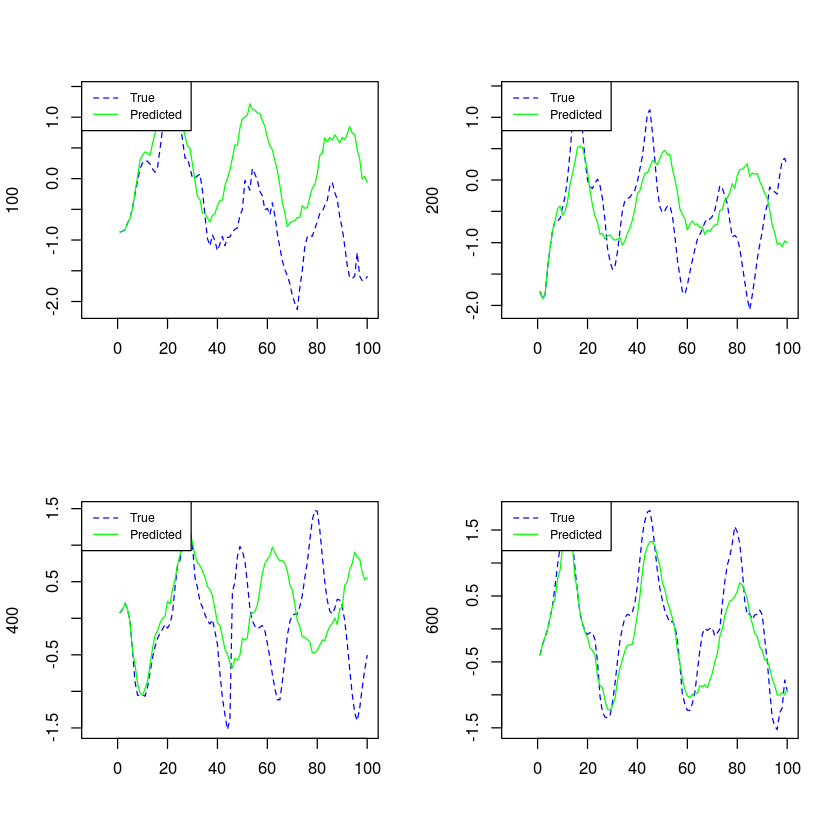

In [37]:
par(mfrow = c(ceiling(length(data_idx)/2),2));
for (i in 1:length(data_idx))
{
    start <- data_idx[i];

    plot.true <- batchdata[(start - crbm$delay):(start + 100 - crbm$delay - 1), 2];
    plot.pred <- generated_series[i, 1:100, 2];

    plot(plot.true, col = "blue", type = "l", lty = 2, xlab = "", ylab = data_idx[i],
         xlim = c(-10,100), ylim = c(min(plot.true, plot.pred),max(plot.true, plot.pred)));
    lines(plot.pred, col = "green");
    legend("topleft", legend = c("True", "Predicted"), col = c("blue","green"),
           lty = c(2,1), cex = 0.75, y.intersp = 1);
}

### Native R CNNs: the MNIST example (with a revenge)

#### Load Dataset

In [38]:
mnist <- readRDS("../datasets/mnist.rds");

In [39]:
img_size <- c(28,28);

train <- mnist$train;
training_x <- array(train$x, c(nrow(train$x), 1, img_size)) / 255;
training_y <- binarization(train$y);

test <- mnist$test;
testing_x <- array(test$x, c(nrow(test$x), 1, img_size)) / 255;
testing_y <- binarization(test$y);

dataset <- training_x[1:1000,,,, drop=FALSE];
targets <- training_y[1:1000,, drop=FALSE];

newdata <- testing_x[1:1000,,,, drop=FALSE];

#### Prepare the Convolutional MLP Network

In [40]:
batch_size <- 10;

border_mode <- 2;
filter_size <- 5;

win_size <- 3;
stride <- 2;

In [41]:
layers <- list(
    create_conv(n_channels = 1, n_filters = 4, filter_size = 5, scale = 0.1),
    create_pool(win_size = 3, stride = 2),
    create_relu(),
    create_conv(n_channels = 4, n_filters = 16, filter_size = 5, scale = 0.1),
    create_pool(win_size = 3, stride = 2),
    create_relu(),
    create_flat(),
    create_line(n_visible = 784, n_hidden = 64, scale = 0.01),
    create_relu(),
    create_line(n_visible = 64, n_hidden = 10, scale = 0.1),
    create_soft()
);

#### Run the CNN

In [42]:
start.time <- Sys.time()

cnn1 <- train_cnn(training_x = dataset,
                  training_y = targets,
                  layers = layers,
                  batch_size = batch_size,
                  training_epochs = 3,
                  learning_rate = 1e-3,
                  rand_seed = 1234
);

end.time <- Sys.time()
time.taken <- end.time - start.time
time.taken

[1] "Epoch 1 : Mean Loss 2.67100944150687"
[1] "Epoch 1 took 0.631250325838725 minutes"
[1] "Epoch 2 : Mean Loss 2.67100930689183"
[1] "Epoch 2 took 0.580683290958405 minutes"
[1] "Epoch 3 : Mean Loss 2.67100932558078"
[1] "Epoch 3 took 0.578489255905151 minutes"


Time difference of 1.7905 mins

In [43]:
str(cnn1)

List of 2
 $     :List of 2
  ..$ layers    :List of 11
  .. ..$ :List of 15
  .. .. ..$ n_channels : num 1
  .. .. ..$ n_filters  : num 4
  .. .. ..$ filter_size: num 5
  .. .. ..$ w_shape    : num [1:4] 4 1 5 5
  .. .. ..$ W          : num [1:4, 1, 1:5, 1:5] -0.0355 0.1026 0.0818 -0.0216 -0.0231 ...
  .. .. ..$ b          : num [1, 1:4, 1, 1] 2.75e-04 -2.69e-04 1.18e-03 -2.09e-06
  .. .. ..$ padding    : num [1:2] 2 2
  .. .. ..$ pnames     :function ()  
  .. .. ..$ gnames     :function ()  
  .. .. ..$ forward    :function (conv, x)  
  .. .. ..$ backward   :function (conv, dy)  
  .. .. ..$ get_updates:function (conv, lr)  
  .. .. ..$ x          : num [1:10, 1, 1:28, 1:28] 0 0 0 0 0 0 0 0 0 0 ...
  .. .. ..$ grad_W     : num [1:4, 1, 1:5, 1:5] -6.83e-05 2.92e-04 -1.70e-03 1.01e-04 -2.24e-04 ...
  .. .. ..$ grad_b     : num [1, 1:4, 1, 1] -0.0025 -0.003627 0.003709 -0.000361
  .. ..$ :List of 9
  .. .. ..$ win_size   : num 3
  .. .. ..$ stride     : num 2
  .. .. ..$ padding    : 